In [19]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import transforms

import base

In [20]:
torch.__version__

'1.13.0'

### 数据

In [21]:
PATH_G = './pth/mnist_GAN(GC).pth'
PATH_D = './pth/mnist_GAN(DC).pth'
PATH_T = './pth/test_input.pt'

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [23]:
train_data_set = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [24]:
dataloader = torch.utils.data.DataLoader(train_data_set, batch_size=64, shuffle=True)

### 生成器

In [25]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 490),
            nn.ReLU()
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(10, 1, 4, 4),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 10, 7, 7)
        x = self.conv(x)
        return x

### 判别器

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 4),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.Dropout(0.5),
            nn.Linear(120, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

### 初始化模型,优化器,损失函数

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [29]:
d_optim = optim.Adam(discriminator.parameters(), lr=0.001)
g_optim = optim.Adam(generator.parameters(), lr=0.001)

In [30]:
loss_func = nn.BCELoss()

### 绘图

In [31]:
def gen_image_plot(model, t_input):
    prediction = np.squeeze(model(t_input).detach().cpu().numpy())
    plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow((prediction[i] + 1) / 2)
        plt.axis('off')
    plt.show()

In [32]:
try:
    test_input = torch.load(PATH_T, map_location=device)
except FileNotFoundError:
    test_input = torch.randn(16, 100, device=device)
    torch.save(test_input, PATH_T)

### 训练

In [33]:
D_loss = []
G_loss = []

In [34]:
def train(epoch, save=True, load=True):
    t = time.time()
    try:
        if load:
            generator.load_state_dict(torch.load(PATH_G, map_location=device)) and \
            discriminator.load_state_dict(torch.load(PATH_D, map_location=device))
    except FileNotFoundError:
        pass
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader)
    for (img, _) in dataloader:
        img = img.to(device)
        size = img.size(0)
        random_noise = torch.randn(size, 100, device=device)

        d_optim.zero_grad()
        real_out = discriminator(img)
        d_real_loss = loss_func(real_out, torch.ones_like(real_out))
        d_real_loss.backward()
        gen_img = generator(random_noise)
        fake_out = discriminator(gen_img.detach())
        d_fake_loss = loss_func(fake_out, torch.zeros_like(fake_out))
        d_fake_loss.backward()
        d_loss = d_real_loss + d_fake_loss
        d_optim.step()

        g_optim.zero_grad()
        fake_out_g = discriminator(gen_img)
        g_loss = loss_func(fake_out_g, torch.ones_like(fake_out_g))
        g_loss.backward()
        g_optim.step()

        with torch.no_grad():
            d_epoch_loss += d_loss
            g_epoch_loss += g_loss
    with torch.no_grad():
        d_epoch_loss /= count
        g_epoch_loss /= count
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        print('Epoch:', epoch)
        print('d-Loss:', d_epoch_loss)
        print('g-Loss:', g_epoch_loss)
        gen_image_plot(generator, test_input)
    if save:
        torch.save(generator.state_dict(), PATH_G)
        torch.save(discriminator.state_dict(), PATH_D)
    epoch -= 1
    print(time.time() - t)
    print()
    if epoch:
        train(epoch, save, save)

In [35]:
@base.timer
def main():
    train(10, True, True)
    pass

Epoch: 10
d-Loss: tensor(0.1111)
g-Loss: tensor(6.0480)


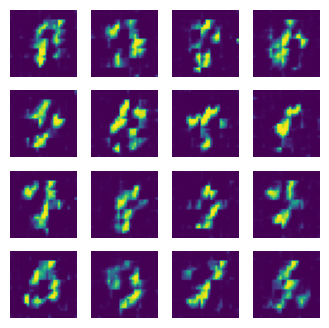

35.0512809753418

Epoch: 9
d-Loss: tensor(0.3529)
g-Loss: tensor(3.9622)


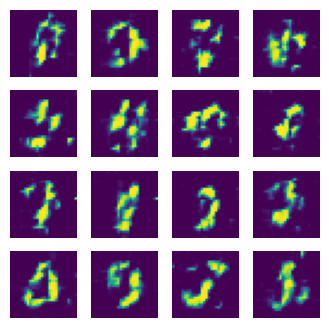

33.52792716026306

Epoch: 8
d-Loss: tensor(0.3929)
g-Loss: tensor(3.7096)


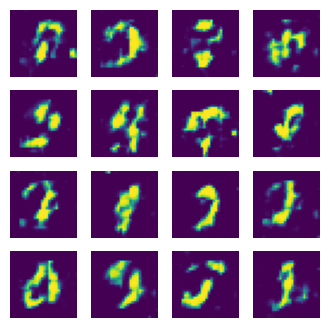

35.597813844680786

Epoch: 7
d-Loss: tensor(0.4217)
g-Loss: tensor(3.6272)


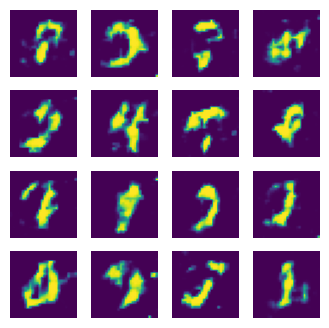

36.16004538536072

Epoch: 6
d-Loss: tensor(0.4064)
g-Loss: tensor(3.6210)


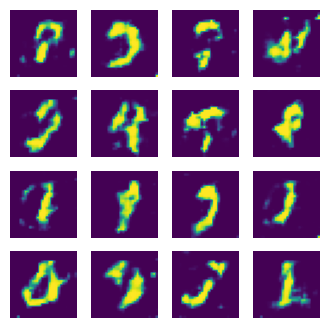

35.14954495429993

Epoch: 5
d-Loss: tensor(0.4038)
g-Loss: tensor(3.5719)


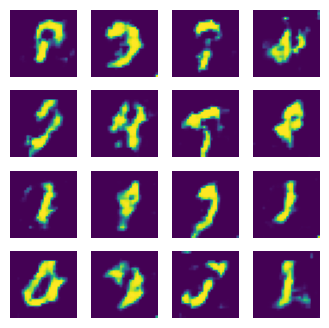

34.47284555435181

Epoch: 4
d-Loss: tensor(0.4094)
g-Loss: tensor(3.5164)


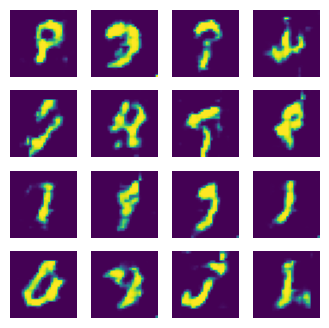

35.1046941280365

Epoch: 3
d-Loss: tensor(0.4048)
g-Loss: tensor(3.4994)


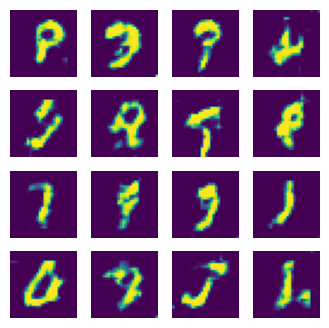

37.46493673324585

Epoch: 2
d-Loss: tensor(0.3970)
g-Loss: tensor(3.5282)


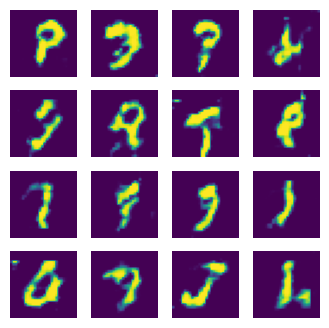

35.5215961933136

Epoch: 1
d-Loss: tensor(0.3899)
g-Loss: tensor(3.5445)


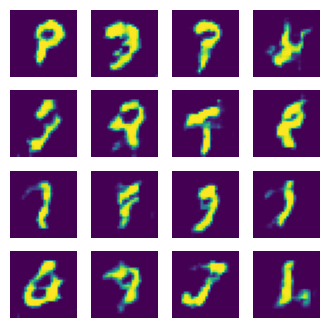

37.38834619522095

main used time: 355.4420368671417s


In [36]:
if __name__ == '__main__':
    main()